# Load hdf file and post-process

For a given model (as guitar_model above), set internal data using hdf5 input. Useful for post-processing only. 

Prerequisite : a complete simulation saved in hdf file (e.g. results of run.py)

### Usage: 

* call load_model function : create a model (dynamical system, interactions and so on) and load results from a previous simu from hdf file
* call post-processing tools

In [46]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# standard python packages
import sys
import time
import os
import pickle
import numpy as np
from model_tools import load_model
# visu
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import scipy.io
import h5py
import simulation_campaigns
import collections

## Select input file(s) and load model(s)

In [49]:
def load(filename):
    if filename.find('bass') >= 0:
        matlab_input = './bass_guitar/pb2'
    elif filename.find('fretless') >= 0:
        matlab_input = './fretless_bass_guitar/bsf'
    elif filename.find('single') >=0 :
        matlab_input = './one_contact/pb1'
    m, s, f, e = load_model(filename)
    frets_file = matlab_input + '_h.mat'
    all_frets_positions = scipy.io.loadmat(frets_file)['h'][:, 0]
    print(m.modal_values)
    #if filename.find('converted') >= 0:
    #    m._convert[...]=False
    #    h5source = h5py.File(filename, 'r')
    #    restit = h5source.attrs['restit']
    #    h5source.close()
    #else:
    #    m.convert_modal_output(s)
    #    restit = None
    return m, s, f, all_frets_positions, e#, restit

Load model from file ./results_bass_1812/F_256901120_id_3966461/converted_bass_e0.9_862_256901120.h5
False
Load model from file ./results_bass_1812/F_4014080_id_3966455/converted_bass_e0.9_862_4014080.h5
False
Load model from file ./results_bass_1812/F_4014080_id_3966470/converted_bass_e1.0_862_4014080.h5
False


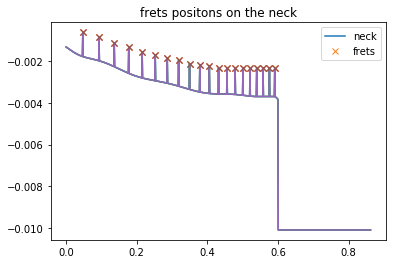

In [50]:
reference_file = './results_bass_1812/F_256901120_id_3966461/converted_bass_e0.9_862_256901120.h5'
current_file = './results_bass_1812/F_4014080_id_3966455/converted_bass_e0.9_862_4014080.h5'
third_file = './results_bass_1812/F_4014080_id_3966470/converted_bass_e1.0_862_4014080.h5'

#reference_file = './results_bass_1812/F_10000000.0_id_4073976/converted_single_e0.0_999_10000000.h5'
##current_file = './results_bass_1812/F_10000000.0_id_4073982/converted_single_e0.5_999_10000000.h5'
#third_file = './results_bass_1812/F_10000000.0_id_4073988/converted_single_e1.0_999_10000000.h5'



#reference_file = './results_bass_1812/F_4014080_id_3966625/converted_fretless_e0.0_862_4014080.h5'


#matlab_frets = './bass_guitar/pb2'
#matlab_fretless = './fretless_bass_guitar/bsf'
guitar_model, guitar_string, guitar_frets, frets_pos, restit = load(reference_file)
current_model, current_string, current_frets, frets_pos, current_e = load(current_file)
m3, s3, f3, fp3, e3 = load(third_file)


if reference_file.find('bass_e') >=0:
    fig_path = 'fig_1812_' + str(int(guitar_model.fs))
elif reference_file.find('fretless_e') >=0:
    fig_path = 'fig_1812_fretless_' + str(int(guitar_model.fs))
elif reference_file.find('single_e') >=0:
    fig_path = 'fig_1812_one_contact' + str(int(guitar_model.fs))
if not os.path.exists(fig_path):
    os.mkdir(fig_path)


    

## Plot trajectories
Use plotTraj(dynamical_system, list of dof to be plotted)

If list of dof is not set, all dof will be plotted.

Result = dof as a function of time +  zoom specific ranges (as in the paper)

To save the resulting figure(s), add argument filename when calling plotTraj

Arg 'iplot' is used to change figure number. Set same iplot if you want to plot all curves on the same figure.
Default iplot=0.

In [59]:
inter = guitar_frets[19]
inter.contact_index

590

In [52]:
print(fig_path)

fig_1812_256901120


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

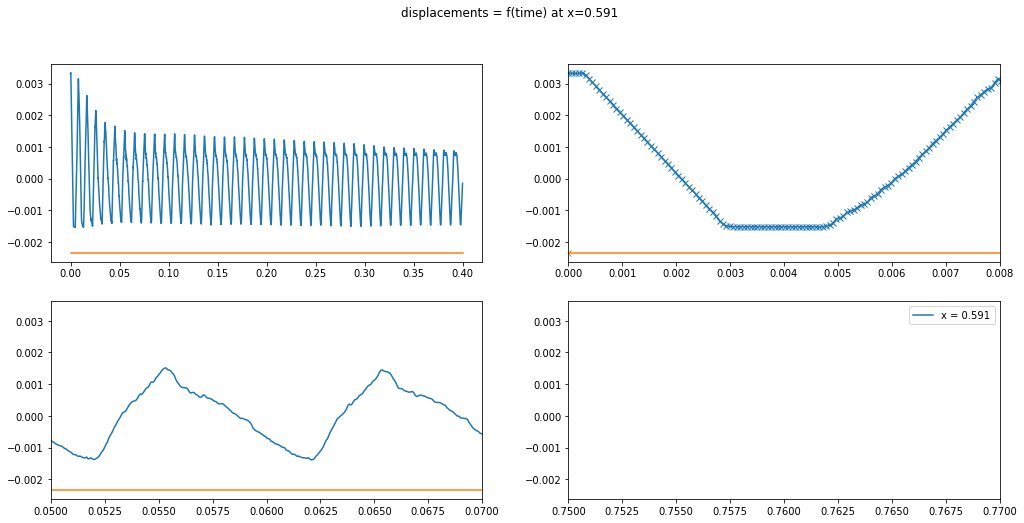

In [60]:
# Select dof to plot traj
dof = 590
ground = frets_pos[dof]#- guitar_string.diameter*0.5
#print(ground)
freq = guitar_model.fs
filename = os.path.join(fig_path, 'traj_' + str(freq) + '_x=' + str(dof) + '.pdf')
guitar_model.plot_traj(guitar_string, dof=dof, iplot=0, ground=ground)#, filename=filename)
#current_model.plot_traj(current_string, dof=dof, iplot=0)#, filename=filename)
#m3.plot_traj(s3, dof=dof, iplot=0)#, filename=filename)


#dof = 9
#ground = frets_pos[dof]#- guitar_string.diameter*0.5
#filename = os.path.join(fig_path, 'traj_' + str(freq) + '_x=' + str(dof) + '.pdf')
#guitar_model.plot_traj(guitar_string, dof=dof, iplot=1, filename=filename)#, ground=ground)
#guitar_model2.plot_traj(guitar_string2, dof=dof, iplot=0, )#, ground=ground

(0, 0.008)

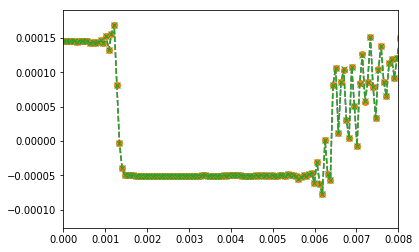

In [64]:
dof = 853
traj = guitar_model.data_ds[guitar_string][dof,:]
traj2 = current_model.data_ds[current_string][dof,:]
traj3= m3.data_ds[s3][dof,:]
t2 = current_model.time
t3 = m3.time
plt.plot(guitar_model.time, traj, '--',t2, traj2, 'o:' , t3, traj3, '--x')
plt.xlim(0, 0.008)

In [ ]:
inter = guitar_model.data_interactions

In [ ]:
ic = 0
time = guitar_model.time
y = inter[guitar_frets[ic]][0][:]
#ydot = inter[frets[ic]][:,1]
plt.figure()
for ic in range(len(guitar_frets)):
    lamb = inter[guitar_frets[ic]][1][:]
    #print(np.where(lamb >=1e-22))
    plt.plot(time, lamb, 'o')


    
#plt.plot(time, ydot,'--x')
plt.xlim(0,0.05)
#plt.ylim(-10,10)
ind = np.where(y<0)
ind2 = np.where(y>=0)

plt.figure(44)
#plt.clf()
plt.plot(time[ind2], y[ind2], 'k:o', time[ind], y[ind], 'rx:', )
plt.xlim(0.003, 0.009)
#plt.figure()

#plt.plot(time, lamb, 'k:o')
                               

# Plot modes

Use guitar_model.plot_modes(guitar_string,plot_shape)

plot_shape = (x,y) where x,y is the resolution of the grid of plots.

Example: 
plot_modes(guitar_string, (4,2)) : splits time range in 8 and plots dof=f(x) for those 8 time instants on 8 figures


Set filename arg to save resulting figure in a file.

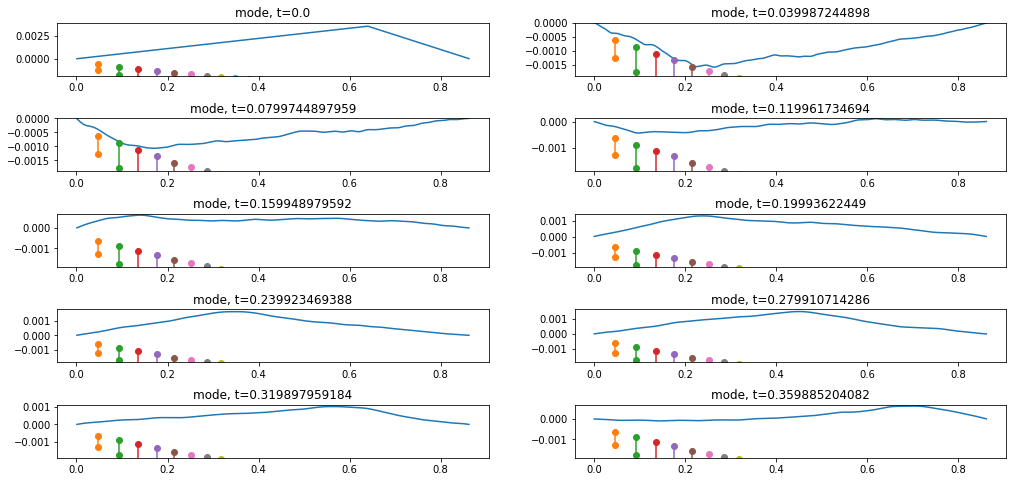

In [65]:
# Plot 10 figures on two columns, for 10 time instants
guitar_model.plot_modes(guitar_string,plot_shape=[5,2], iplot=0)
plt.savefig(os.path.join(fig_path, 'modes.pdf'))
# Same thing but save output in modes.pdf
#guitar_model.plot_modes(guitar_string,plot_shape=[5,3], filename='modes.pdf', iplot=1)
# plot modes for time[12] and time[5000] on one column
#guitar_model.plot_modes(guitar_string, times =[12, 1200], plot_shape=(2,1), filename='modes2.pdf', iplot=2)

## Plot contactogram

    !! Works only if enable_interactions_output=True in model (guitar_model) constructor

In [75]:
guitar_model.time_step

3.8925482302295922e-09

nb contacts :  20


6272

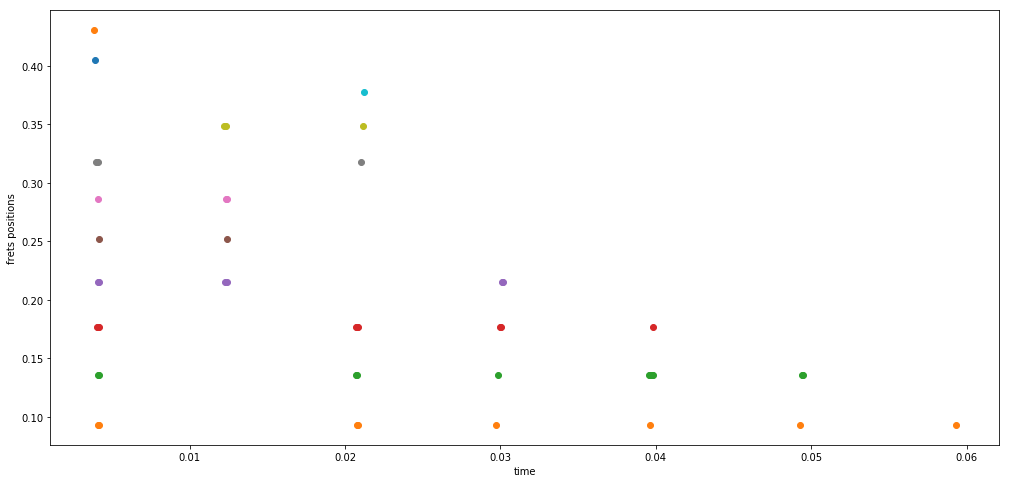

In [76]:
guitar_model.contactogram(guitar_string, 33)
#plt.xlim(0.0035, 0.0045)
plt.savefig(os.path.join(fig_path, 'contacto.pdf'))
guitar_model.nb_time_steps_output

## Create a movie mode=f(time)

fig_1812_256901120/converted_bass_e0.9_862_256901120.mp4


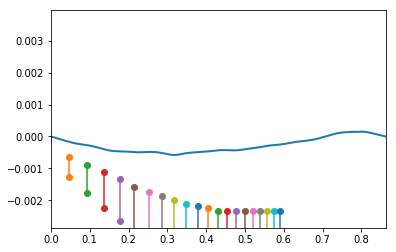

In [78]:
moviename = os.path.basename(reference_file)
moviename = os.path.join(fig_path, os.path.splitext(moviename)[0] + '.mp4')
print(moviename)
#moviename = 'tmp.mp4'
guitar_model.make_movie(guitar_string, moviename, sampling=2)

In [77]:
if os.path.exists(('./last.mp4')):
    os.remove('./last.mp4')
os.symlink(moviename, 'last.mp4')

<video controls src="last.mp4" />
#%%html
#<video width="320" height="240" controls>
#  <source src="./last.mp4" type="video/mp4">
#</video>